<a href="https://colab.research.google.com/github/YMGYM/TSE_Learning/blob/master/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

This is my parctice file which train a Deep-learning model

I used CNN layers, and dataset is from [here](https://www.kaggle.com/asdasdasasdas/garbage-classification)

# Import dataset and preprocessing

## unzip and load

In [1]:
!unzip -q /content/drive/My\ Drive/Datasets/garbage.zip  -d ./dataset

In [2]:
import pathlib

data_dir = pathlib.Path('/content/dataset/garbage classification/Garbage classification')
num_of_images = len(list(data_dir.glob('*/*.jpg')))

print(num_of_images)

2527


## Get classes name

In [3]:
import numpy as np

CLASSES = [item.name for item in data_dir.glob('*')]
np_classes = np.array(CLASSES)
CLASSES

['cardboard', 'plastic', 'glass', 'trash', 'paper', 'metal']

## Import Keras and DataGenerator

In [4]:
import tensorflow.keras as K

In [7]:
image_generator = K.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, brightness_range=(0.5,1.0), validation_split=0.2 )

In [8]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

In [9]:
generated_train_data = image_generator.flow_from_directory(directory=data_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), class_mode='categorical', classes=CLASSES, batch_size=BATCH_SIZE, shuffle=True, subset='training')

Found 2024 images belonging to 6 classes.


In [10]:
generated_validation_data = image_generator.flow_from_directory(directory=data_dir, class_mode='categorical', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),classes=CLASSES, batch_size=BATCH_SIZE, shuffle=True, subset='validation')

Found 503 images belonging to 6 classes.


## Show Image

In [ ]:
import matplotlib.pyplot as plt

def show_image(image_batch, label_batch):
  plt.figure(figsize = (10,10))
  for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(np_classes[label_batch[n] == 1][0].title())
    plt.axis('off')

# Model Import

가장 기본적인 LeNet-5 을 조금 변형

In [13]:
DROPOUT_RATE = 0.1

In [14]:
model_input_layer = K.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
cnn_1 = K.layers.Conv2D(filters=8, kernel_size=(8,8), activation="relu")(model_input_layer)
pool_1 = K.layers.MaxPool2D()(cnn_1)
drop_1 = K.layers.Dropout(DROPOUT_RATE)(pool_1)
norm_1 = K.layers.BatchNormalization()(drop_1)

cnn_2 = K.layers.Conv2D(filters=32, kernel_size=(16,16), activation="relu")(norm_1)
pool_2 = K.layers.MaxPool2D()(cnn_2)
norm_2 = K.layers.BatchNormalization()(pool_2)
# drop_2 = K.layers.Dropout(DROPOUT_RATE)(norm_2)


cnn_2_1 = K.layers.Conv2D(filters=32, kernel_size=(16,16), activation="relu")(norm_2)
norm_3 = K.layers.BatchNormalization()(cnn_2_1)

cnn_3 = K.layers.Conv2D(filters=16, kernel_size=(4,4), activation="relu")(norm_3)
pool_3 = K.layers.MaxPool2D()(cnn_3)
norm_3 = K.layers.BatchNormalization()(pool_3)
# drop_2 = K.layers.Dropout(DROPOUT_RATE)(norm_3)

flatten = K.layers.Flatten()(norm_3)


dense_1 = K.layers.Dense(100, activation='relu')(flatten)
drop_3 = K.layers.Dropout(DROPOUT_RATE)(dense_1)

model_output_layer = K.layers.Dense(len(CLASSES), activation="softmax")(drop_3)

model = K.Model(inputs=model_input_layer, outputs=model_output_layer)

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 243, 243, 8)       1544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 8)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 121, 121, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 32)      65568     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)       

In [63]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

## IMPORT Resnet50

In [11]:
resnet = K.applications.ResNet50(include_top=False)
resnet.trainable=False

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
model = K.Sequential()
model.add(resnet)
model.add(K.layers.GlobalAveragePooling2D())
# model.add(K.layers.Flatten())

model.add(K.layers.Dense(1024,activation="relu"))
model.add(K.layers.Dense(len(CLASSES), activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 25,692,038
Trainable params: 2,104,326
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
adam = K.optimizers.Adam(learning_rate=0.0001)

In [15]:
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=[K.metrics.categorical_accuracy])

## Model load

In [16]:
import tensorflow as tf

In [28]:
latest = tf.train.latest_checkpoint('/content/drive/My Drive/trained_model/garbage/')

In [29]:
# model.load_weights(latest)

In [17]:
EPOCHS = 400

In [18]:
cp_callback = K.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/trained_model/garbage/garbageRES', save_weights_only=True, save_best_only=True, verbose=1)
# cp_callback = K.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/trained_model/garbage/garbage1', save_weights_only=True, verbose=1)

In [ ]:
model.fit(generated_train_data, epochs=EPOCHS, validation_data = generated_validation_data, callbacks=[cp_callback])

Epoch 1/400
64/64 [==============================] - ETA: 0s - loss: 0.9243 - categorical_accuracy: 0.6670
Epoch 00001: val_loss improved from inf to 0.78205, saving model to /content/drive/My Drive/trained_model/garbage/garbageRES
64/64 [==============================] - 180s 3s/step - loss: 0.9243 - categorical_accuracy: 0.6670 - val_loss: 0.7821 - val_categorical_accuracy: 0.7117
Epoch 2/400
64/64 [==============================] - ETA: 0s - loss: 0.5150 - categorical_accuracy: 0.8350
Epoch 00002: val_loss improved from 0.78205 to 0.67841, saving model to /content/drive/My Drive/trained_model/garbage/garbageRES
64/64 [==============================] - 175s 3s/step - loss: 0.5150 - categorical_accuracy: 0.8350 - val_loss: 0.6784 - val_categorical_accuracy: 0.7515
Epoch 3/400
64/64 [==============================] - ETA: 0s - loss: 0.4110 - categorical_accuracy: 0.8701
Epoch 00003: val_loss improved from 0.67841 to 0.60108, saving model to /content/drive/My Drive/trained_model/garbage

In [30]:
def show_predict_image(image_batch, label_batch):
  plt.figure(figsize = (30,30))
  for n in range(100):
    ax = plt.subplot(10, 10, n+1)
    plt.imshow(image_batch[n])
    prediction = model.predict(image_batch[n:n+1]).argmax()
    if prediction != 5:
      plt.title(np_classes[prediction].title() + "/" + np_classes[label_batch[n] == 1][0].title())
    else:
      plt.title(np_classes[prediction].title() + "/" + np_classes[label_batch[n] == 1][0].title())
    plt.axis('off')

In [31]:
i, l = generated_validation_data[0]

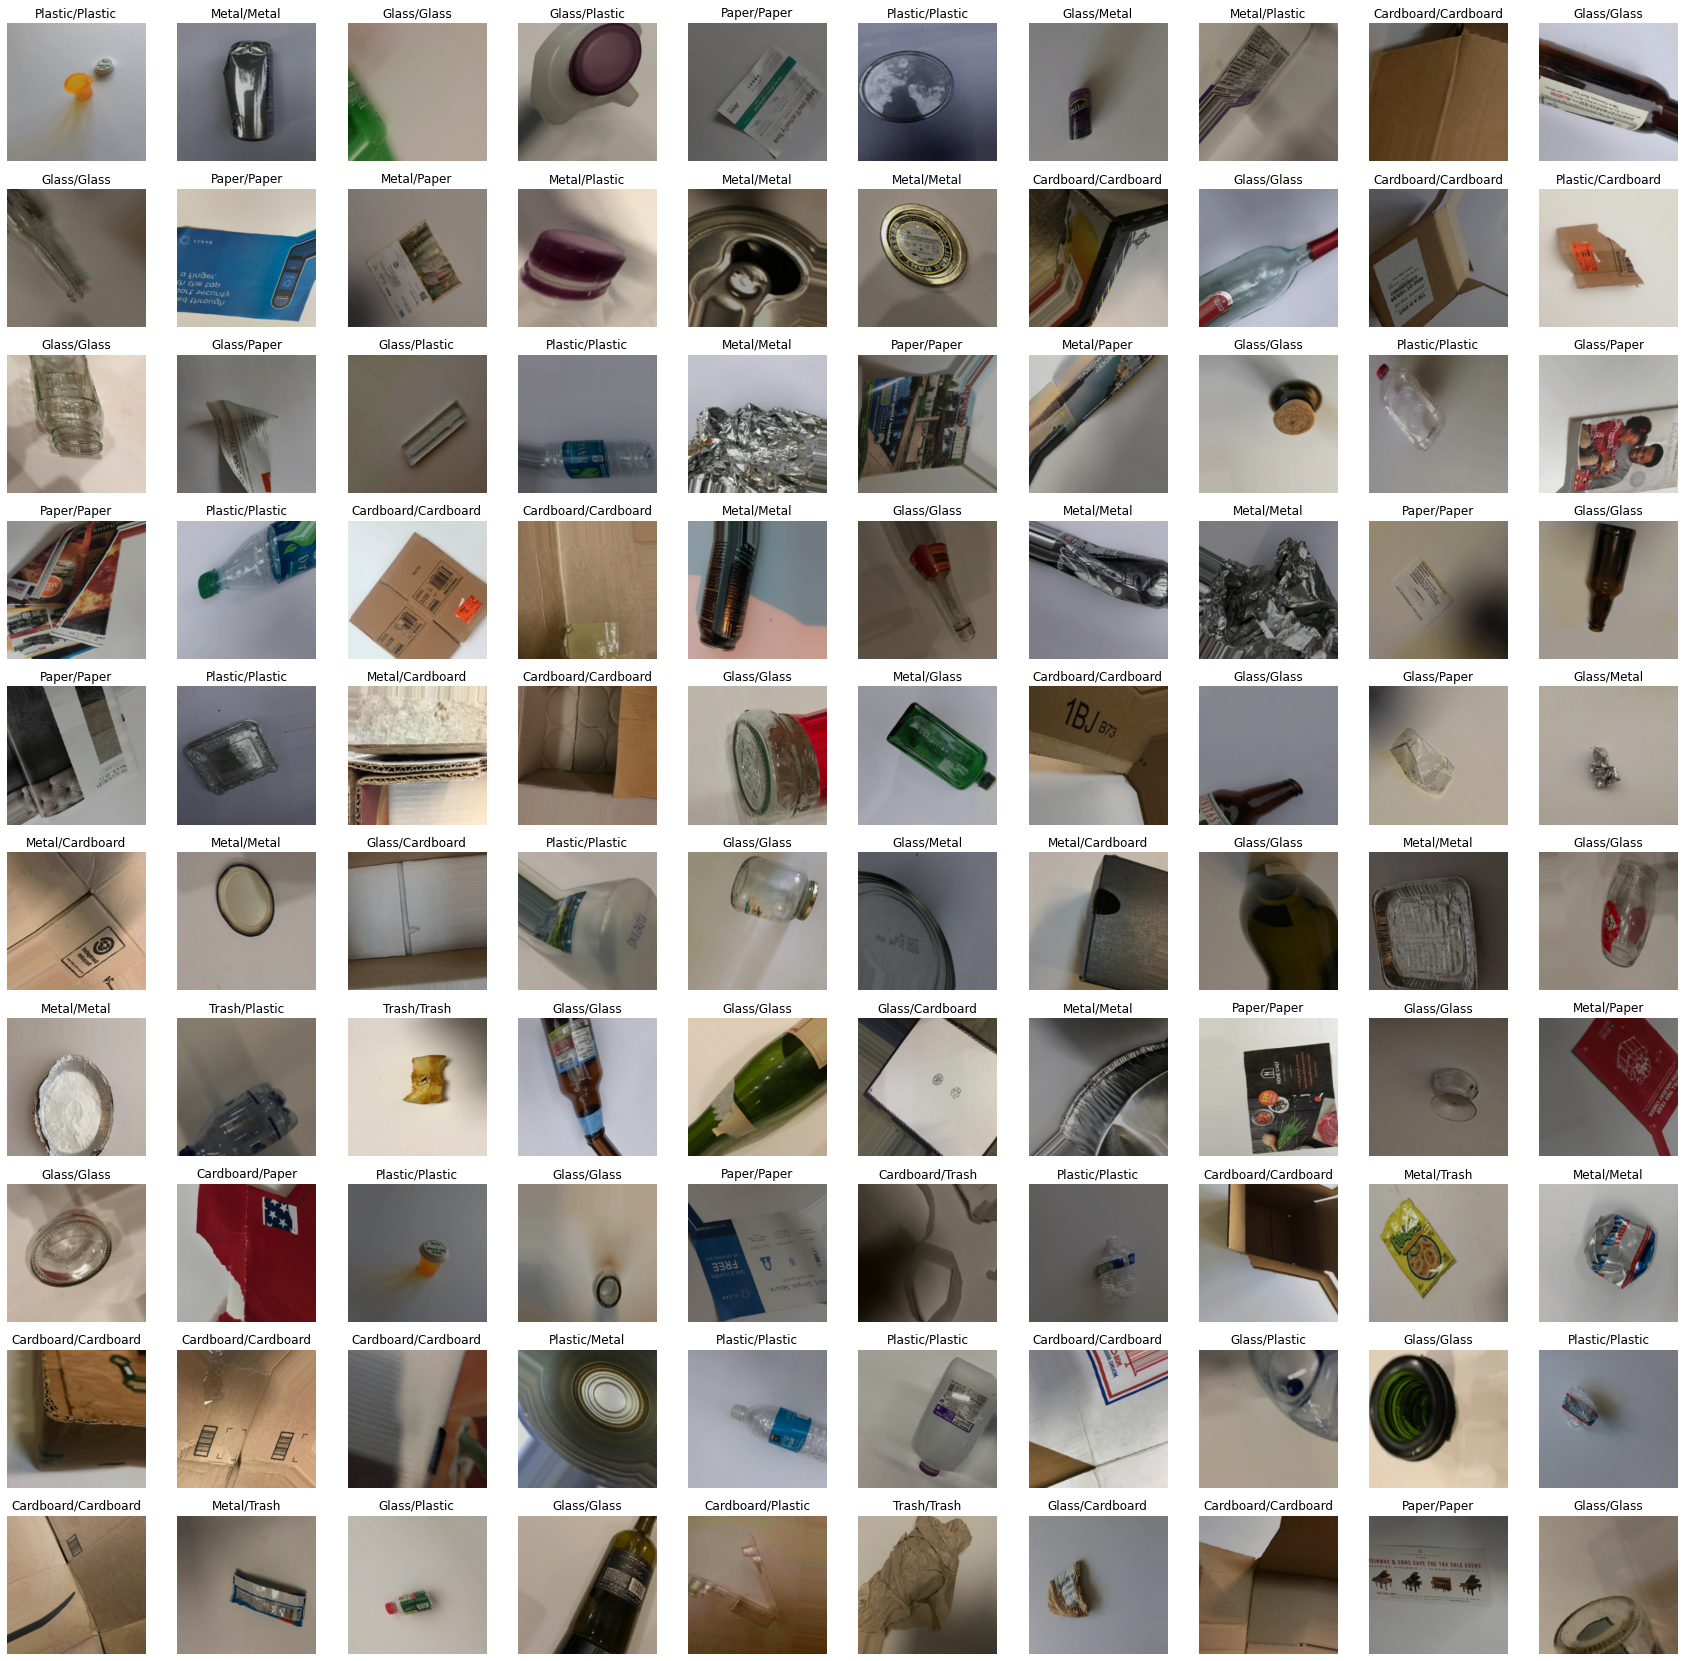

In [25]:
show_predict_image(i, l)